Please upload the dataset file (CSV or ZIP format):


Saving US Airline Flight Routes and Fares 1993-2024.csv to US Airline Flight Routes and Fares 1993-2024 (3).csv

Dataset loaded successfully!
Shape: (245955, 23)

First 5 rows:
       tbl  Year  quarter  citymarketid_1  citymarketid_2  \
0  Table1a  2021        3           30135           33195   
1  Table1a  2021        3           30135           33195   
2  Table1a  2021        3           30140           30194   
3  Table1a  2021        3           30140           30194   
4  Table1a  2021        3           30140           30466   

                            city1                          city2  airportid_1  \
0  Allentown/Bethlehem/Easton, PA  Tampa, FL (Metropolitan Area)        10135   
1  Allentown/Bethlehem/Easton, PA  Tampa, FL (Metropolitan Area)        10135   
2                 Albuquerque, NM          Dallas/Fort Worth, TX        10140   
3                 Albuquerque, NM          Dallas/Fort Worth, TX        10140   
4                 Albuquerque, NM                  

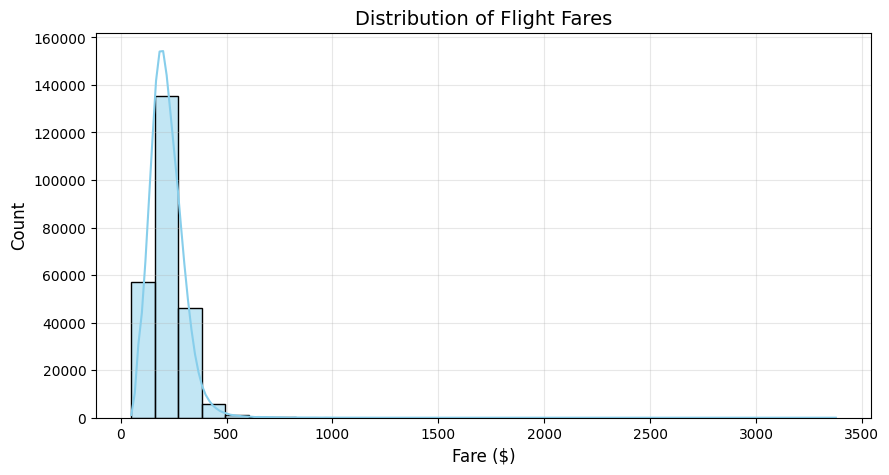

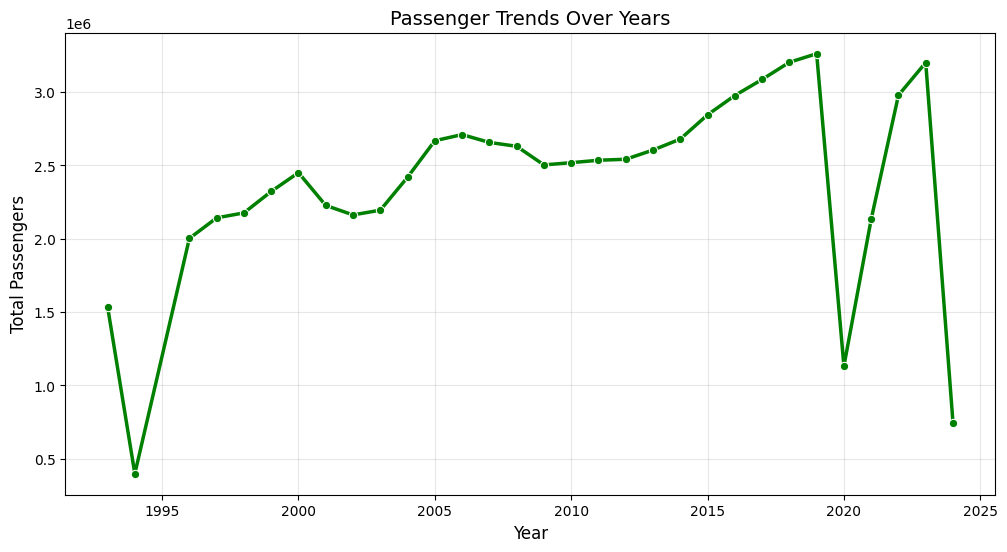

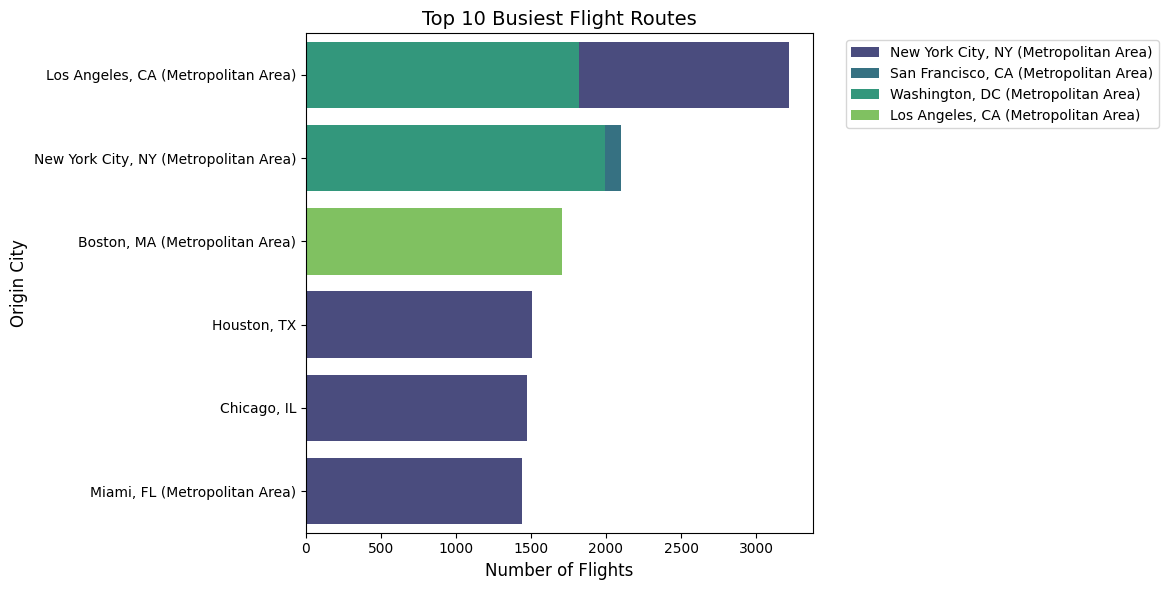

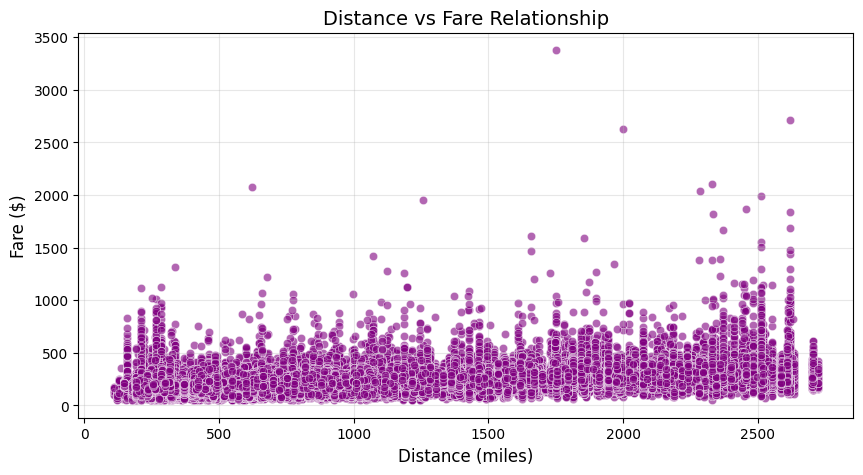

<ipython-input-5-252a5f988646>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=carrier_share, x='carrier_lg', y='large_ms', palette='rocket')


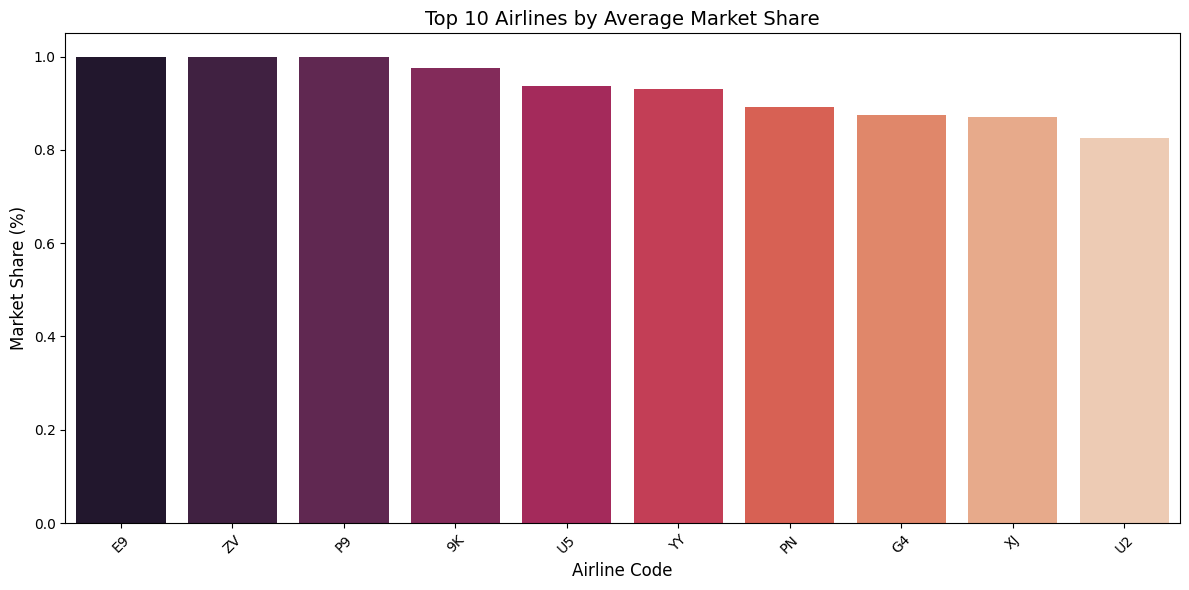


Generating additional visual insights...


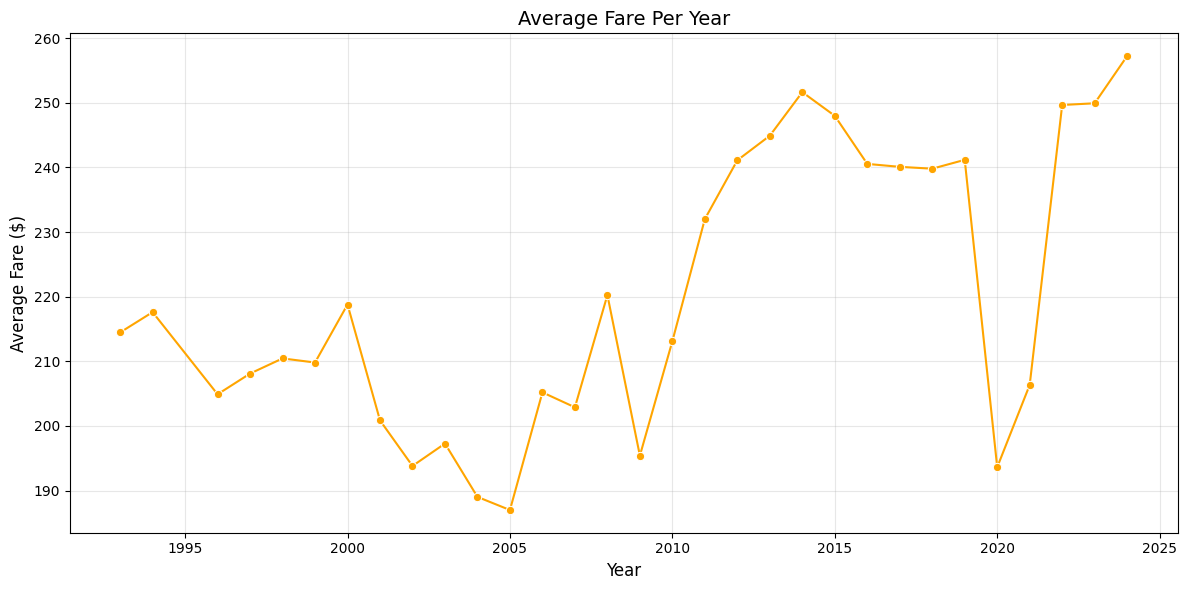

<ipython-input-5-252a5f988646>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_destinations, x='Flight Count', y='Destination City', palette='coolwarm')


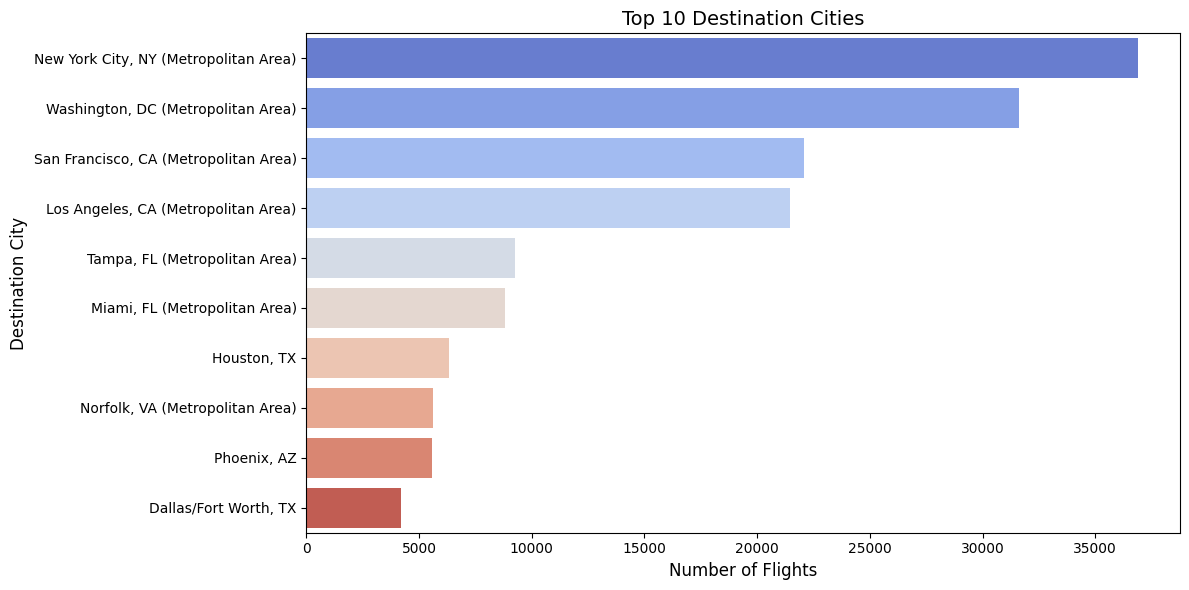

<ipython-input-5-252a5f988646>:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='quarter', y='fare', palette='Set2')


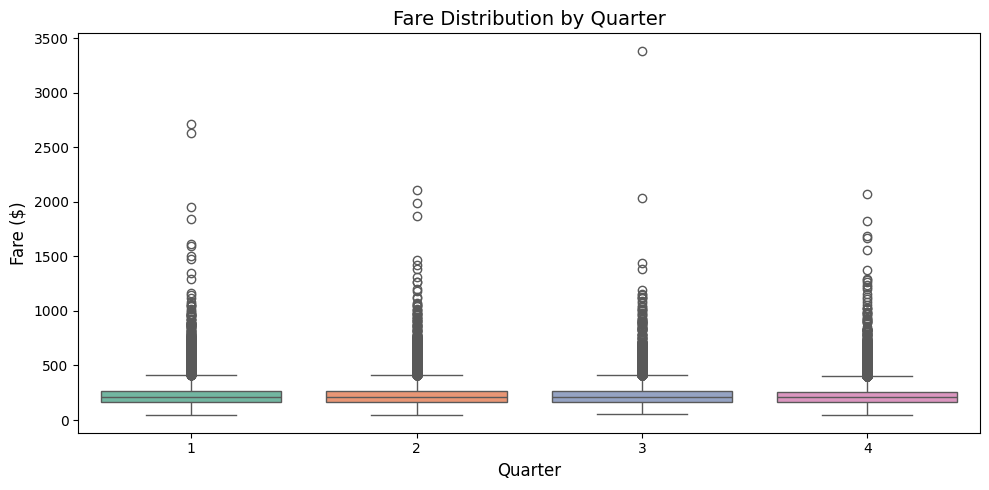


Creating geospatial map...


Geospatial map saved as 'flight_routes_map.html'


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from google.colab import files
import io
import zipfile
import os

# Step 1: Load the dataset
def load_data():
    print("Please upload the dataset file (CSV or ZIP format):")
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]

    if file_name.endswith('.zip'):
        with zipfile.ZipFile(io.BytesIO(uploaded[file_name]), 'r') as zip_ref:
            zip_ref.extractall("extracted")
            csv_files = [f for f in os.listdir("extracted") if f.endswith(".csv")]
            if csv_files:
                file_name = os.path.join("extracted", csv_files[0])
            else:
                raise FileNotFoundError("No CSV file found in the ZIP archive.")
    else:
        file_name = io.BytesIO(uploaded[file_name])

    try:
        return pd.read_csv(file_name, encoding='utf-8', low_memory=False)
    except UnicodeDecodeError:
        return pd.read_csv(file_name, encoding='ISO-8859-1', low_memory=False)

# Step 2: Data Cleaning
def clean_data(df):
    # Convert columns to appropriate types
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['quarter'] = df['quarter'].astype('category')

    # Drop rows with missing essential values
    df = df.dropna(subset=['fare', 'passengers', 'nsmiles'])
    return df

# Step 3: Visualization Functions
def plot_fare_distribution(df):
    plt.figure(figsize=(10, 5))
    sns.histplot(df['fare'], bins=30, kde=True, color='skyblue')
    plt.title("Distribution of Flight Fares", fontsize=14)
    plt.xlabel("Fare ($)", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_passenger_trends(df):
    plt.figure(figsize=(12, 6))
    yearly_passengers = df.groupby('Year')['passengers'].sum().reset_index()
    sns.lineplot(data=yearly_passengers, x='Year', y='passengers',
                 marker='o', color='green', linewidth=2.5)
    plt.title("Passenger Trends Over Years", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Total Passengers", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_top_routes(df):
    top_routes = df.groupby(['city1', 'city2']).size().nlargest(10).reset_index(name='count')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_routes, y='city1', x='count', hue='city2', dodge=False, palette='viridis')
    plt.title("Top 10 Busiest Flight Routes", fontsize=14)
    plt.xlabel("Number of Flights", fontsize=12)
    plt.ylabel("Origin City", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_distance_vs_fare(df):
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=df, x='nsmiles', y='fare', alpha=0.6, color='purple')
    plt.title("Distance vs Fare Relationship", fontsize=14)
    plt.xlabel("Distance (miles)", fontsize=12)
    plt.ylabel("Fare ($)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_carrier_market_share(df):
    plt.figure(figsize=(12, 6))
    carrier_share = df.groupby('carrier_lg')['large_ms'].mean().nlargest(10).reset_index()
    sns.barplot(data=carrier_share, x='carrier_lg', y='large_ms', palette='rocket')
    plt.title("Top 10 Airlines by Average Market Share", fontsize=14)
    plt.xlabel("Airline Code", fontsize=12)
    plt.ylabel("Market Share (%)", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def create_geospatial_map(df):
    # Create a base map centered on the US
    us_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4, tiles='CartoDB positron')

    # Add markers for origin cities
    origin_coords = df[['city1', 'Geocoded_City1']].drop_duplicates()
    for _, row in origin_coords.iterrows():
        try:
            lat, lon = map(float, row['Geocoded_City1'].split(','))
            folium.CircleMarker(
                location=[lat, lon],
                radius=3,
                color='blue',
                fill=True,
                fill_color='blue',
                popup=row['city1']
            ).add_to(us_map)
        except:
            continue

    return us_map

# ➕ Additional visualizations
def plot_avg_fare_per_year(df):
    plt.figure(figsize=(12, 6))
    avg_fare = df.groupby('Year')['fare'].mean().reset_index()
    sns.lineplot(data=avg_fare, x='Year', y='fare', marker='o', color='orange')
    plt.title("Average Fare Per Year", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Average Fare ($)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_top_destination_cities(df):
    plt.figure(figsize=(12, 6))
    top_destinations = df['city2'].value_counts().nlargest(10).reset_index()
    top_destinations.columns = ['Destination City', 'Flight Count']
    sns.barplot(data=top_destinations, x='Flight Count', y='Destination City', palette='coolwarm')
    plt.title("Top 10 Destination Cities", fontsize=14)
    plt.xlabel("Number of Flights", fontsize=12)
    plt.ylabel("Destination City", fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_fare_by_quarter(df):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='quarter', y='fare', palette='Set2')
    plt.title("Fare Distribution by Quarter", fontsize=14)
    plt.xlabel("Quarter", fontsize=12)
    plt.ylabel("Fare ($)", fontsize=12)
    plt.tight_layout()
    plt.show()

# Main execution
def main():
    # Load and clean data
    df = load_data()
    print("\nDataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())

    df = clean_data(df)

    # Generate visualizations
    print("\nGenerating visualizations...")
    plot_fare_distribution(df)
    plot_passenger_trends(df)
    plot_top_routes(df)
    plot_distance_vs_fare(df)
    plot_carrier_market_share(df)

    # Additional visualizations
    print("\nGenerating additional visual insights...")
    plot_avg_fare_per_year(df)
    plot_top_destination_cities(df)
    plot_fare_by_quarter(df)

    # Create geospatial map
    print("\nCreating geospatial map...")
    map_obj = create_geospatial_map(df)
    from IPython.display import display
    display(map_obj)  # Show directly in Colab
    map_obj.save("flight_routes_map.html")
    print("Geospatial map saved as 'flight_routes_map.html'")

if __name__ == "__main__":
    main()
